In [1]:
import os
from google.cloud import vision
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.transform import rotate, resize, rescale
import ultralytics
from ultralytics import YOLO
from concurrent.futures import ThreadPoolExecutor
ultralytics.checks()

# Our scripts
from Python_Helpers.image_loading import * 
from Python_Helpers.preprocessing import * 
from Python_Helpers.corrections import *
from Python_Helpers.ID_isolation import *
from Python_Helpers.YOLO import *

# YOLO stuff.
relevant_characters = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'B',10:'F',11:'G',12:'K',13:'N',14:'O',15:'P',16:'R',17:'S',18:'V',19:'W',20:'Y', 21:''}
letter_model_path = '../YOLO_Data/YOLOletters.pt'
number_model_path = '../YOLO_Data/YOLOnumbers.pt'

# Google cloud tocken and files
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"guppies-test-4c48569421d8.json"
file_list = ListAvaliableFiles('guppy_images', prefix='Manually_Labelled/New', verbose=True)
random.shuffle(file_list)

Ultralytics YOLOv8.0.189  Python-3.11.3 torch-2.0.1+cpu CPU (AMD Ryzen 5 3600 6-Core Processor)
Setup complete  (12 CPUs, 16.0 GB RAM, 189.4/465.1 GB disk)



Files have been read.


In [2]:
# Runs an image file through the whole code and outputs two predictions (google and YOLO) along with the initial and ID images.
def MainFunction(file_name, padx=80, pady=20, delta_width=10, probability_threshold=0.5, verbose=False):
    # Initial google read and preprocessing of image.
    image = RetreiveImage('guppy_images', file_name, verbose=verbose)

    decoded = np.frombuffer(image.getvalue(), dtype=np.uint8)
    initial_image = cv2.imdecode(decoded, cv2.IMREAD_COLOR)

    if verbose: plt.imshow(initial_image)

    Initial_Results = GoogleRead(image, verbose=verbose)
    Processed_Results, title, ID, date = PreprocessLabel(Initial_Results, verbose=verbose)

    # Corrected google prediction.
    title, ID, date = CorrectOutput(title, ID, date)

    # Identity isolation and YOLO ID results
    ID_Dictionary = IsolateIdentity(Processed_Results, padx=padx, pady=pady, delta_width=delta_width, verbose=verbose)
    plt.imsave('./Temp_YOLO_File.jpg', ID_Dictionary['frame'])
    characters, boxes, probs, letter_idx = UseYOLO(letter_model_path, number_model_path, './Temp_YOLO_File.jpg', probability_threshold=probability_threshold, verbose=verbose)
    os.remove('./Temp_YOLO_File.jpg')
    # Correct ID obtained from file name.
    correctID = file_name.split("/")[-1].split('.')[0][3:-4]

    if verbose:
        print('\nGoogle prediction:', '-'.join([title, ID, date]))
        print('YOLO prediction:', '-'.join([title, ''.join(characters), date]))
        print('Correct ID:', correctID)

        plt.imshow(ID_Dictionary['frame'])

    return '-'.join([title, ID, date]), '-'.join([title, ''.join(characters), date]), correctID, initial_image, ID_Dictionary['frame']


image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 128x256 1 S, 50.0ms
Speed: 0.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 128x256 1 5, 36.0ms
Speed: 0.0ms preprocess, 36.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 256)




#######################
Google Prediction: FLL-4O5B-10/26/11
YOLO Prediction: FLL-5-10/26/11
Correct ID: 4O5B
#######################


Text(0.5, 1.0, 'Final ID')

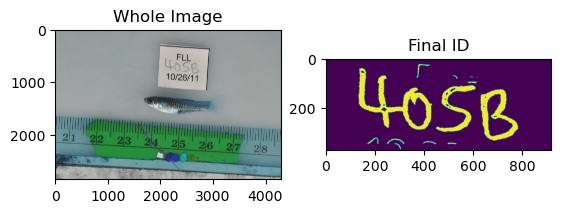

In [3]:
file_name = random.choice(file_list)
Google_Prediction, YOLO_Prediction, correctID, initial_image, ID_image = MainFunction(file_name, verbose=False)

print('\n\n#######################')
print('Google Prediction:', Google_Prediction)
print('YOLO Prediction:', YOLO_Prediction)
print('Correct ID:', correctID)
print('#######################')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(initial_image)
ax2.imshow(ID_image)

ax1.set_title('Whole Image')
ax2.set_title('Final ID')

In [4]:
%%capture
# Can be used to check where errors are being raised and what is raising them.
exceptions = []

for i in range(10):  
    file_name = random.choice(file_list)
    try:
        Google_Prediction, YOLO_Prediction, correctID, initial_image, ID_image = MainFunction(file_name, verbose=False)
    except Exception as e: exceptions.append(e)

print(len(exceptions))
# print(exceptions)


image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 128x256 1 P, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 128x256 1 0, 1 8, 37.0ms
Speed: 0.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 96x256 1 B, 35.0ms
Speed: 0.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 96x256 1 3, 1 4, 30.0ms
Speed: 1.0ms preprocess, 30.0ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 96x256 (no detections), 29.0ms
Speed: 1.0ms preprocess, 29.0ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)

image 1/1 c:\Users\newc6448\Projects\Guppies\Temp_YOLO_File.jpg: 96x

In [5]:
# Function returns just the ID image. Can be used to check the ID_isolation process.
def ImageFunction(file_name, padx=80, pady=20, delta_width=10, verbose=False):
    # Initial google read and preprocessing of image.
    image = RetreiveImage('guppy_images', file_name, verbose=verbose)

    Initial_Results = GoogleRead(image, verbose=verbose)
    Processed_Results = PreprocessLabel(Initial_Results, verbose=verbose)[0]

    # Identity isolation and YOLO ID results
    ID_Dictionary = IsolateIdentity(Processed_Results, padx=padx, pady=pady, delta_width=delta_width, verbose=verbose)

    return ID_Dictionary['frame']


# A function that can be ran in parallel which appends the images to a list.
def ParallelImageFunction(file):
    ID_image = ImageFunction(file)
    images.append(ID_image)
    return

In [6]:
random.shuffle(file_list)

files = file_list[:400]
images = []

from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor() as executor:
    executor.map(ParallelImageFunction, files)

print(len(images))

389


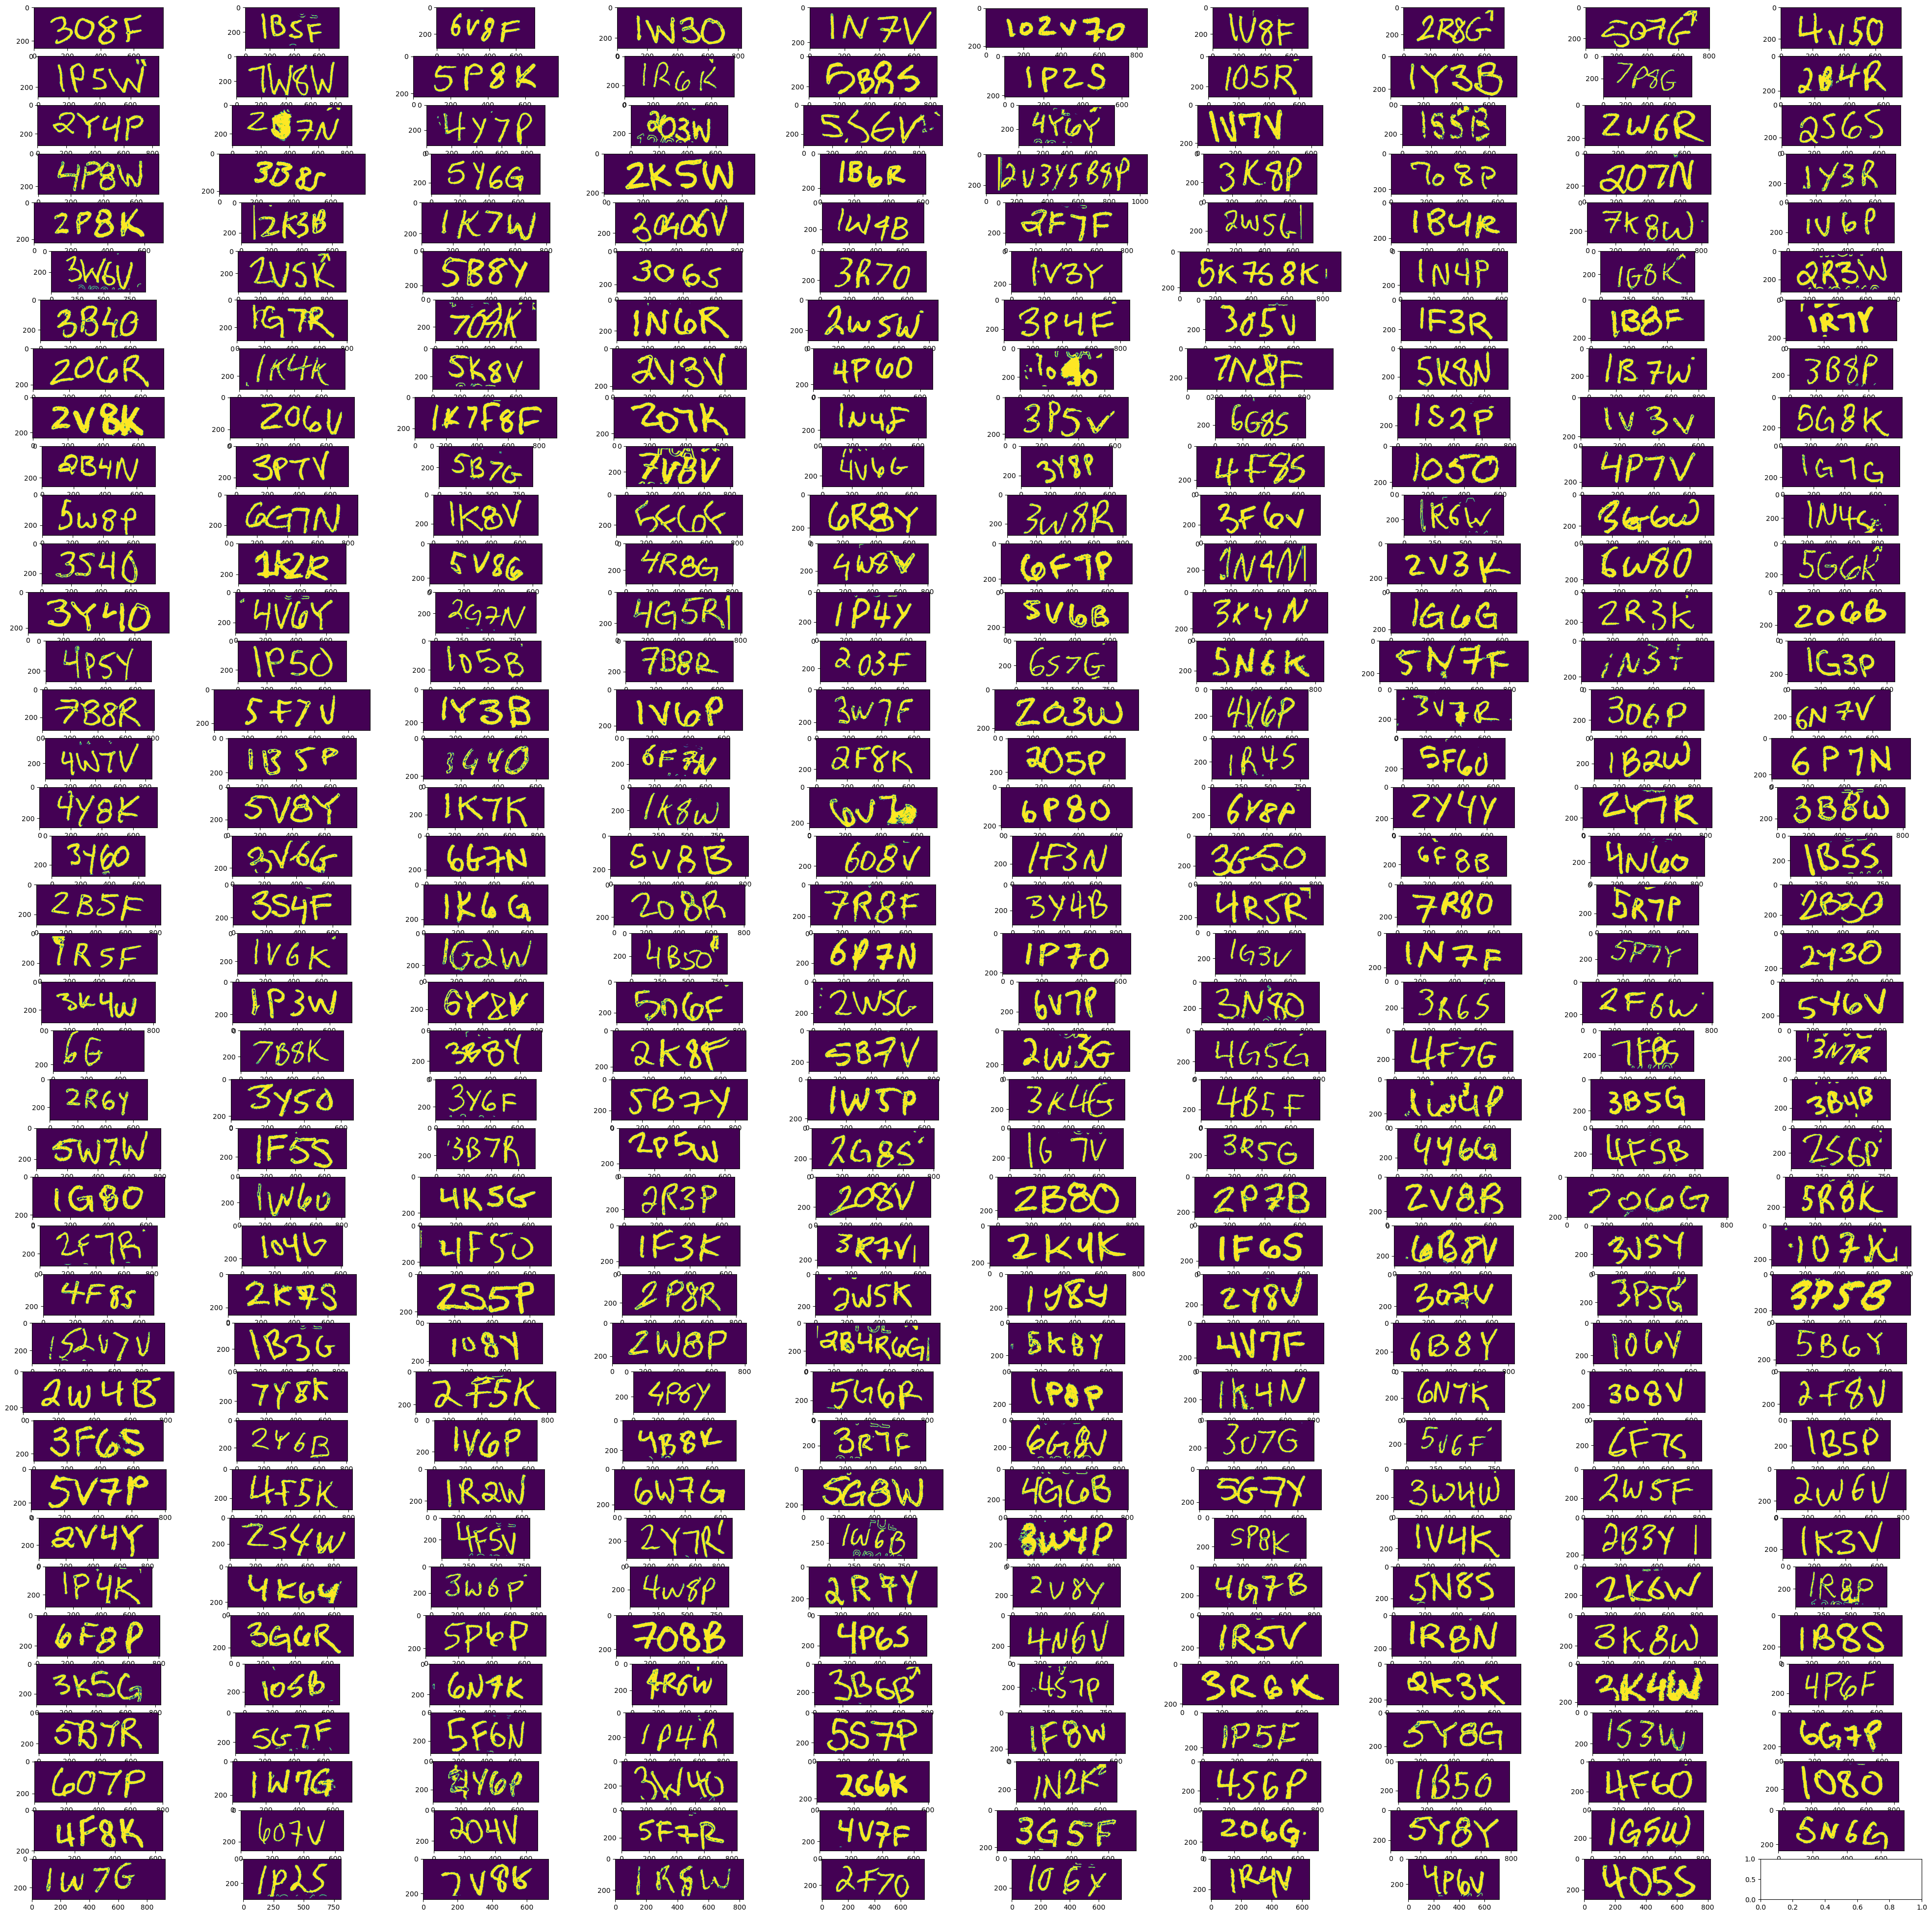

In [7]:
fig,ax = plt.subplots(39,10, figsize=(50,50))

for n, image in enumerate(images):
    i, j = n//10, n%10
    ax[i,j].imshow(images[n])